## Totale Decessi per regione
### Il codice genera un grafico che mostra il numero di decessi ogni 100.000 abitanti divisi per regione. Oltre al dataset fornito, è stato creato un dataframe importando i dati relativi al numero di abitanti per regione utilizzando il pacchetto BeautifulSoup. Sul dataframe creato con l'importazione del file csv è stato fatto un replace per accorpare i dati delle province autonome di Bolzano e Trento rinominandoli entrambi Trantino-Alto Adige in modo da rendere possibile il merge con l'altro dataframe e rendere i dati uniformati con le altre regioni. Inoltre all'interno del dataset i valori della colonna Deaths rappresentano i numero totale di decessi dall'inizio della pandemia; quindi per poter calcolare il numero totale dei decessi è stata presa in considerazione la differenza tra il valore Deaths con quello del giorno precedente.

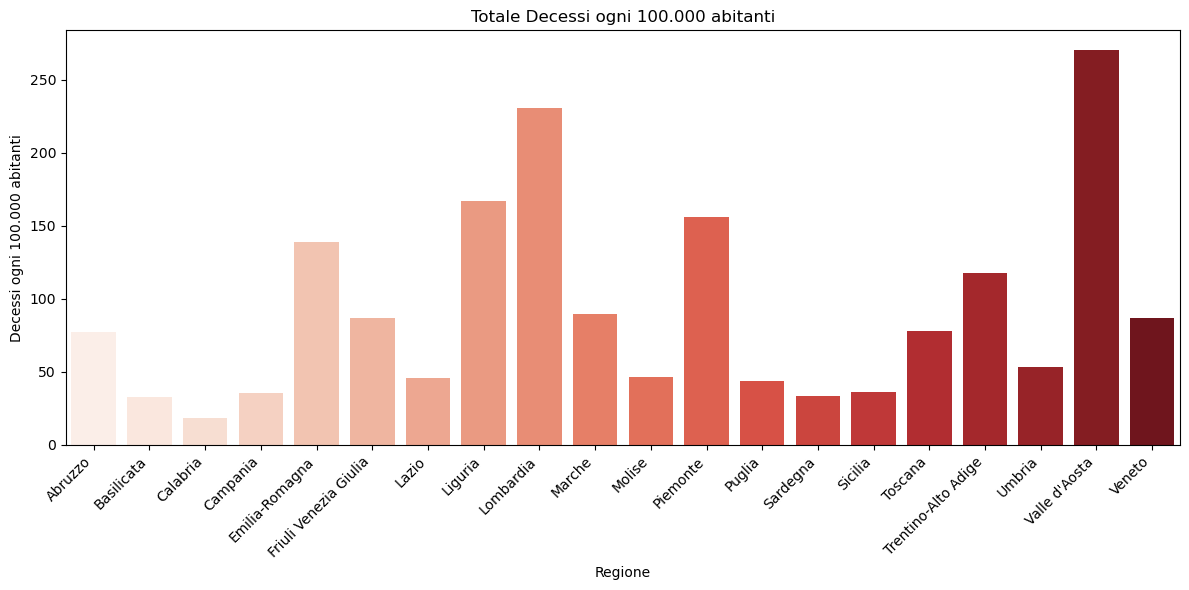

In [9]:
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

# Carico e leggo il dataset delle regioni
    file_path_regione = 'covid19_italy_region _python.csv'
    df_regione = pd.read_csv(file_path_regione)

    
# Ordina il DataFrame per 'RegionName' e 'Date'
    df_regione = df_regione.sort_values(by=['RegionName', 'Date'])

# Calcola la differenza giornaliera per la colonna 'Deaths' raggruppata per 'RegionName'
    df_regione['DailyDeaths'] = df_regione.groupby('RegionName')['Deaths'].diff().fillna(df_regione['Deaths'])
    
# Aggiorna i valori nella colonna RegionName del DataFrame df_regione
    df_regione['RegionName'].replace({'P.A. Bolzano': 'Trentino-Alto Adige', 'P.A. Trento': 'Trentino-Alto Adige'}, inplace=True)



# Carico e leggo il dataset della densità di popolazione per regione
    url = 'https://www.tuttitalia.it/regioni/densita/'
    response = requests.get(url)

# Parsing dell'HTML con BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

# Trova la tabella che contiene i dati sulla densità di popolazione
    table = soup.find('table', {'class': 'ut'})

# Estrai le righe della tabella
    rows = table.find_all('tr')

# Inizializza una lista per i dati
    data = []

# Itera sulle righe della tabella
    for row in rows[1:]:  # Ignora la riga delle intestazioni
    # Estrai le colonne
        cols = row.find_all('td')
    # Estrai i dati dalle colonne e rimuovi eventuali spazi superflui
        regione = cols[1].text.strip()
        abitanti = cols[2].text.strip()
    # Aggiungi i dati alla lista
        data.append([regione, abitanti])

# Crea un DataFrame pandas dai dati
    df_abitanti = pd.DataFrame(data, columns=['Regione', 'Abitanti'])
    df_abitanti['Abitanti'] = df_abitanti['Abitanti'].replace('\.', '', regex=True)

# Merge df_regione e df_abitanti 
    df_merged = pd.merge(df_regione, df_abitanti, left_on='RegionName', right_on='Regione')

# Converte 'Abitanti' in valore numerico
    df_merged['Abitanti'] = pd.to_numeric(df_merged['Abitanti'].str.replace('.', ''))

# Calcolare il totale di morti per regione
    total_death = df_merged.groupby('RegionName')['DailyDeaths'].sum()

# Calcola newpositivecases per 100,000 abitanti
    df_merged['Deaths_per_100k'] = (df_merged['DailyDeaths'] / df_merged['Abitanti']) * 100000

# Raggruppa per regione e fa la somma dei nuovi casi positivi ogni 100K abitanti
    total_deaths_per_100k = df_merged.groupby('RegionName')['Deaths_per_100k'].sum()

# Crea grafico a barre
    plt.figure(figsize=(12, 6))
    sns.barplot(x=total_deaths_per_100k.index, y=total_deaths_per_100k.values, palette="Reds")
    plt.xticks(rotation=45, ha='right')
    plt.title("Totale Decessi ogni 100.000 abitanti")
    plt.xlabel('Regione')
    plt.ylabel('Decessi ogni 100.000 abitanti')
    plt.tight_layout()
    
# Salva il grafico come un'immagine PNG
    plt.savefig('TotaleDecessi100K.png')

    plt.show()
